# 第 8  章  数据规整：聚合、合并和重塑

在许多应用中，数据可能分散在许多文件或数据库中，存储的形式也不利于分
析。本章关注可以聚合、合并、重塑数据的方法。
首先，我会介绍 pandas 的层次化索引，它广泛用于以上操作。然后，我深入介
绍了一些特殊的数据操作。在第 14 章，你可以看到这些工具的多种应用。
## 8.1 层次化索引
层次化索引（hierarchical indexing）是 pandas 的一项重要功能，它使你能
在一个轴上拥有多个（两个以上）索引级别。抽象点说，它使你能以低维度形
式处理高维度数据。我们先来看一个简单的例子：创建一个 Series，并用一个
由列表或数组组成的列表作为索引：

In [1]:
import pandas as pd
import numpy as np

data = pd.Series(np.random.randn(9),
                 index=[['a', 'a', 'a', 'b', 'b', 'c', 'c','d', 'd'],
                        [1, 2, 3, 1, 3, 1, 2, 2, 3]])

In [2]:
data

a  1   -0.568400
   2    1.251578
   3   -0.782956
b  1    1.572990
   3   -1.163448
c  1    0.667198
   2   -0.558769
d  2   -0.215139
   3    1.144913
dtype: float64

看到的结果是经过美化的带有 MultiIndex 索引的 Series 的格式。索引之间的
“间隔”表示“直接使用上面的标签”：

In [3]:
data.index

MultiIndex(levels=[['a', 'b', 'c', 'd'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 0, 2, 0, 1, 1, 2]])

对于一个层次化索引的对象，可以使用所谓的部分索引，使用它选取数据子集
的操作更简单：

In [4]:
data['b']

1    1.572990
3   -1.163448
dtype: float64

In [5]:
data['b':'c']

b  1    1.572990
   3   -1.163448
c  1    0.667198
   2   -0.558769
dtype: float64

In [6]:
data.loc[['b', 'd']]

b  1    1.572990
   3   -1.163448
d  2   -0.215139
   3    1.144913
dtype: float64

有时甚至还可以在“内层”中进行选取：

In [7]:
data.loc[:, 2]

a    1.251578
c   -0.558769
d   -0.215139
dtype: float64

层次化索引在数据重塑和基于分组的操作（如透视表生成）中扮演着重要的角
色。例如，可以通过 unstack 方法将这段数据重新安排到一个 DataFrame 中：

In [9]:
data.unstack()
# 好像转置

,1,2,3
a,-0.568400,1.251578,-0.782956
b,1.572990,NaN,-1.163448
c,0.667198,-0.558769,NaN
d,NaN,-0.215139,1.144913


unstack 的逆运算是 stack：

In [10]:
data.unstack().stack()

a  1   -0.568400
   2    1.251578
   3   -0.782956
b  1    1.572990
   3   -1.163448
c  1    0.667198
   2   -0.558769
d  2   -0.215139
   3    1.144913
dtype: float64

stack 和 unstack 将在本章后面详细讲解。

对于一个 DataFrame，每条轴都可以有分层索引：

In [11]:
frame = pd.DataFrame(np.arange(12).reshape((4, 3)),
                     index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                     columns=[['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']])

In [12]:
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

各层都可以有名字（可以是字符串，也可以是别的 Python 对象）。如果指定了
名称，它们就会显示在控制台输出中：

In [13]:
frame.index.names = ['key1', 'key2']

In [14]:
frame.columns.names = ['state', 'color']

In [15]:
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

注意：小心区分索引名 state、color 与行标签。

有了部分列索引，因此可以轻松选取列分组：

In [16]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

可以单独创建 MultiIndex 然后复用。上面那个 DataFrame 中的（带有分级名
称）列可以这样创建：

In [23]:
# question
multi_index = pd.MultiIndex.from_arrays([['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']],
                       names=['state', 'color'])

In [24]:
multi_index

MultiIndex(levels=[['Colorado', 'Ohio'], ['Green', 'Red']],
           labels=[[1, 1, 0], [0, 1, 0]],
           names=['state', 'color'])

### 重排与分级排序
有时，你需要重新调整某条轴上各级别的顺序，或根据指定级别上的值对数据
进行排序。swaplevel 接受两个级别编号或名称，并返回一个互换了级别的新
对象（但数据不会发生变化）：

In [25]:
# swaplevel 互换
frame.swaplevel('key1', 'key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

而 sort_index 则根据单个级别中的值对数据进行排序。交换级别时，常常也会
用到 sort_index，这样最终结果就是按照指定顺序进行字母排序了：

In [26]:
# sort_index 排序
frame.sort_index(level=1)  # 按照 key2 排序

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [28]:
# sort_index 排序
frame.sort_index(level=0)  # 按照 key1 排序

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

In [29]:
frame.swaplevel(0, 1).sort_index(level=0) # 先互换再排序

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

### 根据级别汇总统计
许多对 DataFrame 和 Series 的描述和汇总统计都有一个 level 选项，它用于指
定在某条轴上求和的级别。再以上面那个 DataFrame 为例，我们可以根据行或
列上的级别来进行求和：

In [30]:
frame.sum(level='key2')

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [31]:
frame.sum(level='color', axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

这其实是利用了 pandas 的 groupby 功能，本书稍后将对其进行详细讲解。
### 使用 DataFrame 的列进行索引
人们经常想要将 DataFrame 的一个或多个列当做行索引来用，或者可能希望将
行索引变成 DataFrame 的列。以下面这个 DataFrame 为例：

In [32]:
frame = pd.DataFrame({'a': range(7), 
                      'b': range(7, 0, -1),
                      'c': ['one', 'one', 'one', 'two', 'two', 'two', 'two'],
                      'd': [0, 1, 2, 0, 1, 2, 3]})

In [33]:
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


DataFrame 的 set_index 函数会将其一个或多个列转换为行索引，并创建一个
新的 DataFrame：

In [34]:
frame2 = frame.set_index(['c', 'd'])
# 列变为索引

In [35]:
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

默认情况下，那些列会从 DataFrame 中移除，但也可以将其保留下来：

In [36]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

reset_index 的功能跟 set_index 刚好相反，层次化索引的级别会被转移到列
里面：

In [37]:
# 索引变为列 set_index 的逆向操作
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


## 8.2 合并数据集
pandas 对象中的数据可以通过一些方式进行合并：
-  pandas.merge 可根据一个或多个键将不同 DataFrame 中的行连接起来。SQL 或其他关系型数据库的用户对此应该会比较熟悉，因为它实现的就是数据库的 join 操作。
-  pandas.concat 可以沿着一条轴将多个对象堆叠到一起。
-  实例方法 combine_first 可以将重复数据编接在一起，用一个对象中的值填充另一个
对象中的缺失值。
我将分别对它们进行讲解，并给出一些例子。本书剩余部分的示例中将经常用
到它们。
### 数据库风格的 DataFrame 合并
数据集的合并（merge）或连接（join）运算是通过一个或多个键将行链接起来
的。这些运算是关系型数据库（基于 SQL）的核心。pandas 的 merge 函数是对
数据应用这些算法的主要切入点。

以一个简单的例子开始：

In [38]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})

In [39]:
df2 = pd.DataFrame({'key': ['a', 'b', 'd'],
                    'data2': range(3)})

In [40]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [41]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


这是一种多对一的合并。df1 中的数据有多个被标记为 a 和 b 的行，而 df2 中
key 列的每个值则仅对应一行。对这些对象调用 merge 即可得到：

In [42]:
pd.merge(df1, df2)

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


注意，我并没有指明要用哪个列进行连接。如果没有指定，merge 就会将重叠
列的列名当做键。不过，最好明确指定一下：

In [43]:
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


如果两个对象的列名不同，也可以分别进行指定：

In [47]:
df3 = pd.DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                    'data1': range(7)})
df3

,lkey,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [48]:
df4 = pd.DataFrame({'rkey': ['a', 'b', 'd'],
                    'data2': range(3)})
df4

,rkey,data2
0,a,0
1,b,1
2,d,2


In [46]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


可能你已经注意到了，结果里面 c 和 d 以及与之相关的数据消失了。默认情况
下，merge 做的是“内连接”；结果中的键是交集。其他方式还有"left"、
"right"以及"outer"。外连接求取的是键的并集，组合了左连接和右连接的效
果：

In [49]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


表 8-1 对这些选项进行了总结。

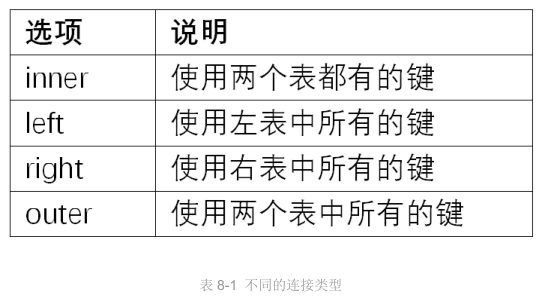

多对多的合并有些不直观。看下面的例子：

In [50]:
df1 = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                    'data1': range(6)})

In [51]:
df2 = pd.DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                    'data2': range(5)})

In [52]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [53]:
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [54]:
pd.merge(df1, df2, on='key', how='left')

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


多对多连接产生的是行的笛卡尔积。由于左边的 DataFrame 有 3 个"b"行，右边
的有 2 个，所以最终结果中就有 6 个"b"行。连接方式只影响出现在结果中的不
同的键的值：

In [55]:
pd.merge(df1, df2, how='inner')

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


要根据多个键进行合并，传入一个由列名组成的列表即可：

In [56]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                     'key2': ['one', 'two', 'one'],
                     'lval': [1, 2, 3]})

In [57]:
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                      'key2': ['one', 'one', 'one', 'two'],
                      'rval': [4, 5, 6, 7]})

In [58]:
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [59]:
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [60]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


结果中会出现哪些键组合取决于所选的合并方式，你可以这样来理解：多个键
形成一系列元组，并将其当做单个连接键（当然，实际上并不是这么回事）。

注意：在进行列－列连接时，DataFrame 对象中的索引会被丢弃。

对于合并运算需要考虑的最后一个问题是对重复列名的处理。虽然你可以手工
处理列名重叠的问题（查看前面介绍的重命名轴标签），但 merge 有一个更实
用的 suffixes 选项，用于指定附加到左右两个 DataFrame 对象的重叠列名上的
字符串：

In [61]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [62]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


merge 的参数请参见表 8-2。使用 DataFrame 的行索引合并是下一节的主题。

表 8-2 merge 函数的参数

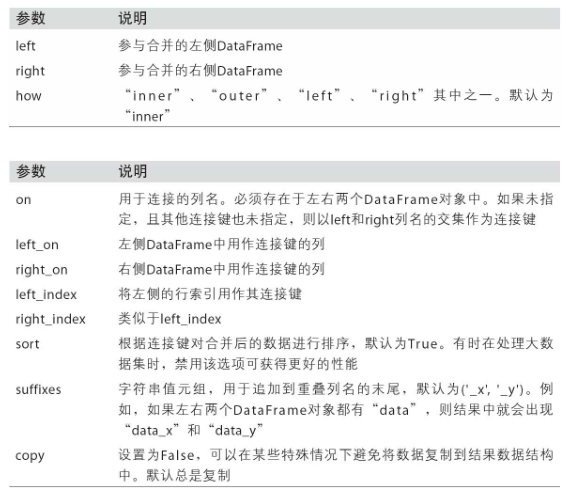

indicator 添加特殊的列_merge，它可以指明每个行的来源，它的值有
left_only、right_only 或 both，根据每行的合并数据的来源。

### 索引上的合并
有时候，DataFrame 中的连接键位于其索引中。在这种情况下，你可以传入
left_index=True 或 right_index=True（或两个都传）以说明索引应该被用作
连接键：

In [63]:
left1 = pd.DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                      'value': range(6)})

In [64]:
right1 = pd.DataFrame({'group_val': [3.5, 7]}, 
                      index=['a','b'])

In [65]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [66]:
right1

,group_val
a,3.5
b,7.0


In [67]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


由于默认的 merge 方法是求取连接键的交集，因此你可以通过外连接的方式得
到它们的并集：

In [68]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


对于层次化索引的数据，事情就有点复杂了，因为索引的合并默认是多键合
并：

In [69]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio','Nevada', 'Nevada'],
                      'key2': [2000, 2001, 2002, 2001, 2002],
                      'data': np.arange(5.)})

In [70]:
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                      index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],
                             [2001, 2000, 2000, 2000, 2001, 2002]],
                      columns=['event1', 'event2'])

In [71]:
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [72]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

这种情况下，你必须以列表的形式指明用作合并键的多个列（注意用
how='outer'对重复索引值的处理）：

In [73]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4,5
0,Ohio,2000,0.0,6,7
1,Ohio,2001,1.0,8,9
2,Ohio,2002,2.0,10,11
3,Nevada,2001,3.0,0,1


In [74]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


同时使用合并双方的索引也没问题：

In [75]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                     index=['a', 'c', 'e'],
                     columns=['Ohio', 'Nevada'])

In [76]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                      index=['b', 'c', 'd', 'e'],
                      columns=['Missouri', 'Alabama'])

In [77]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [79]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [80]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame 还有一个便捷的 join 实例方法，它能更为方便地实现按索引合并。
它还可用于合并多个带有相同或相似索引的 DataFrame 对象，但要求没有重叠
的列。在上面那个例子中，我们可以编写：

In [81]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


因为一些历史版本的遗留原因，DataFrame 的 join 方法默认使用的是左连接，
保留左边表的行索引。它还支持在调用的 DataFrame 的列上，连接传递的
DataFrame 索引：

In [82]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


最后，对于简单的索引合并，你还可以向 join 传入一组 DataFrame，下一节会
介绍更为通用的 concat 函数，也能实现此功能：

In [83]:
another = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [16., 17.]],
                       index=['a', 'c', 'e', 'f'],
                       columns=['New York', 'Oregon'])

In [84]:
another

,New York,Oregon
a,7.0,8.0
c,9.0,10.0
e,11.0,12.0
f,16.0,17.0


In [85]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0,9.0,10.0
e,5.0,6.0,13.0,14.0,11.0,12.0


In [86]:
left2.join([right2, another], how='outer')

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:6369: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  verify_integrity=True)


,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


### 轴向连接
另一种数据合并运算也被称作连接（concatenation）、绑定（binding）或堆
叠（stacking）。NumPy 的 concatenation 函数可以用 NumPy 数组来做：

In [1]:
import pandas as pd
import numpy as np

arr = np.arange(12).reshape((3, 4))

In [2]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [3]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

对于 pandas 对象（如 Series 和 DataFrame），带有标签的轴使你能够进一步
推广数组的连接运算。具体点说，你还需要考虑以下这些东西：
-  如果对象在其它轴上的索引不同，我们应该合并这些轴的不同元素还是只使用交集？
-  连接的数据集是否需要在结果对象中可识别？
-  连接轴中保存的数据是否需要保留？许多情况下，DataFrame 默认的整数标签最好在连接时删掉。
pandas 的 concat 函数提供了一种能够解决这些问题的可靠方式。我将给出一
些例子来讲解其使用方式。假设有三个没有重叠索引的 Series：

In [4]:
s1 = pd.Series([0, 1], index=['a', 'b'])

In [5]:
s2 = pd.Series([2, 3, 4], index=['c', 'd', 'e'])

In [6]:
s3 = pd.Series([5, 6], index=['f', 'g'])

对这些对象调用 concat 可以将值和索引粘合在一起：

In [7]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

默认情况下，concat 是在 axis=0 上工作的，最终产生一个新的 Series。如果
传入 axis=1，则结果就会变成一个 DataFrame（axis=1 是列）：

In [8]:
pd.concat([s1, s2, s3], axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


这种情况下，另外的轴上没有重叠，从索引的有序并集（外连接）上就可以看
出来。传入 join='inner'即可得到它们的交集：

In [9]:
s4 = pd.concat([s1, s3])

In [10]:
s4

a    0
b    1
f    5
g    6
dtype: int64

In [11]:
pd.concat([s1, s4], axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1
a,0.0,0
b,1.0,1
f,NaN,5
g,NaN,6


In [12]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,1


在这个例子中，f 和 g 标签消失了，是因为使用的是 join='inner'选项。
你可以通过 join_axes 指定要在其它轴上使用的索引：

In [13]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,1.0
e,NaN,NaN


不过有个问题，参与连接的片段在结果中区分不开。假设你想要在连接轴上创
建一个层次化索引。使用 keys 参数即可达到这个目的：

In [14]:
result = pd.concat([s1, s1, s3], keys=['one','two', 'three'])

In [15]:
result

one    a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [16]:
result.unstack()

,a,b,f,g
one,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


如果沿着 axis=1 对 Series 进行合并，则 keys 就会成为 DataFrame 的列头：

In [17]:
pd.concat([s1, s2, s3], axis=1, keys=['one','two', 'three'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


同样的逻辑也适用于 DataFrame 对象：

In [18]:
df1 = pd.DataFrame(np.arange(6).reshape(3, 2), 
                   index=['a', 'b', 'c'],
                   columns=['one', 'two'])

In [19]:
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2),
                   index=['a', 'c'],
                   columns=['three', 'four'])

In [20]:
df1

,one,two
a,0,1
b,2,3
c,4,5


In [21]:
df2

,three,four
a,5,6
c,7,8


In [22]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

如果传入的不是列表而是一个字典，则字典的键就会被当做 keys 选项的值：

In [23]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

此外还有两个用于管理层次化索引创建方式的参数（参见表 8-3）。举个例
子，我们可以用 names 参数命名创建的轴级别：

In [24]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
          names=['upper', 'lower'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

最后一个关于 DataFrame 的问题是，DataFrame 的行索引不包含任何相关数
据：

In [25]:
df1 = pd.DataFrame(np.random.randn(3, 4), 
                   columns=['a', 'b', 'c', 'd'])

In [27]:
df2 = pd.DataFrame(np.random.randn(2, 3), 
             columns=['b', 'd', 'a'])

In [28]:
df1

,a,b,c,d
0,3.116556,2.388311,-1.763253,0.119206
1,-0.613371,1.606911,-0.017218,0.929813
2,1.790343,-2.222636,0.716489,0.553688


In [29]:
df2

,b,d,a
0,-0.933959,-0.561102,0.982222
1,-0.565644,0.237580,-0.348218


在这种情况下，传入 ignore_index=True 即可：

In [30]:
pd.concat([df1, df2], ignore_index=True)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,a,b,c,d
0,3.116556,2.388311,-1.763253,0.119206
1,-0.613371,1.606911,-0.017218,0.929813
2,1.790343,-2.222636,0.716489,0.553688
3,0.982222,-0.933959,NaN,-0.561102
4,-0.348218,-0.565644,NaN,0.237580


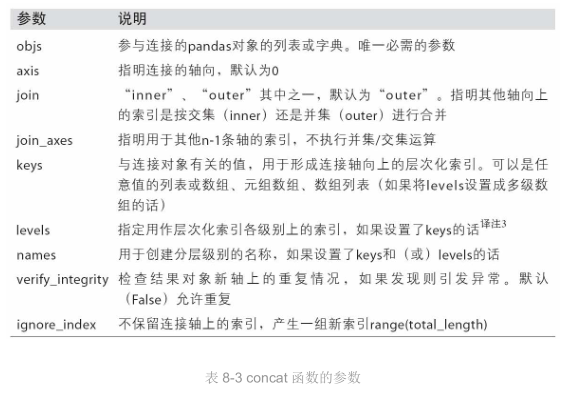

### 合并重叠数据
还有一种数据组合问题不能用简单的合并（merge）或连接（concatenation）
运算来处理。比如说，你可能有索引全部或部分重叠的两个数据集。举个有启
发性的例子，我们使用 NumPy 的 where 函数，它表示一种等价于面向数组的
if-else：

In [31]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
              index=['f', 'e', 'd', 'c', 'b', 'a'])

In [32]:
b = pd.Series(np.arange(len(a), dtype=np.float64),
              index=['f', 'e', 'd', 'c', 'b', 'a'])

In [33]:
b[-1] = np.nan

In [34]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [35]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [36]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Series 有一个 combine_first 方法，实现的也是一样的功能，还带有 pandas
的数据对齐：

>combine_first，也就是数据补齐函数，取两个pandas的非NAN值

In [37]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

In [38]:
b[:-2]

f    0.0
e    1.0
d    2.0
c    3.0
dtype: float64

In [39]:
a[2:]

d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

对于 DataFrame，combine_first 自然也会在列上做同样的事情，因此你可以将
其看做：用传递对象中的数据为调用对象的缺失数据“打补丁”：

In [40]:
df1 = pd.DataFrame({'a': [1., np.nan, 5., np.nan],
                    'b': [np.nan, 2., np.nan, 6.],
                    'c': range(2, 18, 4)})

In [41]:
df2 = pd.DataFrame({'a': [5., 4., np.nan, 3., 7.],
                    'b': [np.nan, 3., 4., 6., 8.]})

In [42]:
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [43]:
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [44]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 8.3 重塑和轴向旋转
有许多用于重新排列表格型数据的基础运算。这些函数也称作重塑（reshape）
或轴向旋转（pivot）运算。
### 重塑层次化索引
层次化索引为 DataFrame 数据的重排任务提供了一种具有良好一致性的方式。
主要功能有二：
-  stack：将数据的列“旋转”为行。
-  unstack：将数据的行“旋转”为列。
我将通过一系列的范例来讲解这些操作。接下来看一个简单的 DataFrame，其
中的行列索引均为字符串数组：

In [45]:
data = pd.DataFrame(np.arange(6).reshape((2, 3)),
                    index=pd.Index(['Ohio', 'Colorado'], name='state'),
                    columns=pd.Index(['one', 'two', 'three'],name='number'))

In [46]:
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


对该数据使用 stack 方法即可将列转换为行，得到一个 Series：

In [47]:
result = data.stack()
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

对于一个层次化索引的 Series，你可以用 unstack 将其重排为一个
DataFrame：

In [48]:
result.unstack()

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


默认情况下，unstack 操作的是最内层（stack 也是如此）。传入分层级别的编
号或名称即可对其它级别进行 unstack 操作：

In [49]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [50]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


如果不是所有的级别值都能在各分组中找到的话，则 unstack 操作可能会引入
缺失数据：

In [51]:
s1 = pd.Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])

In [52]:
s2 = pd.Series([4, 5, 6], index=['c', 'd', 'e'])

In [53]:
data2 = pd.concat([s1, s2], keys=['one', 'two'])

In [54]:
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [55]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


stack 默认会滤除缺失数据，因此该运算是可逆的：

In [56]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


In [57]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [58]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

在对 DataFrame 进行 unstack 操作时，作为旋转轴的级别将会成为结果中的最
低级别：

In [59]:
df = pd.DataFrame({'left': result, 'right': result + 5},
                  columns=pd.Index(['left', 'right'], name='side'))

In [60]:
df

side             left  right
state    number             
Ohio     one        0      5
         two        1      6
         three      2      7
Colorado one        3      8
         two        4      9
         three      5     10

In [61]:
df.unstack('state')

side   left          right         
state  Ohio Colorado  Ohio Colorado
number                             
one       0        3     5        8
two       1        4     6        9
three     2        5     7       10

当调用 stack，我们可以指明轴的名字：

In [62]:
df.unstack('state').stack('side')

state         Colorado  Ohio
number side                 
one    left          3     0
       right         8     5
two    left          4     1
       right         9     6
three  left          5     2
       right        10     7

### 将“长格式”旋转为“宽格式”
多个时间序列数据通常是以所谓的“长格式”（long）或“堆叠格式”
（stacked）存储在数据库和 CSV 中的。我们先加载一些示例数据，做一些时间
序列规整和数据清洗：

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('examples/macrodata.csv')

In [4]:
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [5]:
periods = pd.PeriodIndex(year=data.year,quarter=data.quarter,name='date')

In [6]:
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')

In [7]:
data = data.reindex(columns=columns)

In [8]:
data.index = periods.to_timestamp('D', 'end')

In [9]:
ldata = data.stack().reset_index().rename(columns={0: 'value'})

In [10]:
data.head()

item,realgdp,infl,unemp
date,,,
1959-03-31,2710.349,0.00,5.8
1959-06-30,2778.801,2.34,5.1
1959-09-30,2775.488,2.74,5.3
1959-12-31,2785.204,0.27,5.6
1960-03-31,2847.699,2.31,5.2


In [11]:
ldata.head(6)

,date,item,value
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100


In [12]:
data.stack().head(6)
# stack() 列转换为行索引

date        item   
1959-03-31  realgdp    2710.349
            infl          0.000
            unemp         5.800
1959-06-30  realgdp    2778.801
            infl          2.340
            unemp         5.100
dtype: float64

In [13]:
data.stack().reset_index().head(6)
# reset_index 层次化索引转换为列

,date,item,0
0,1959-03-31,realgdp,2710.349
1,1959-03-31,infl,0.000
2,1959-03-31,unemp,5.800
3,1959-06-30,realgdp,2778.801
4,1959-06-30,infl,2.340
5,1959-06-30,unemp,5.100


这就是多个时间序列（或者其它带有两个或多个键的可观察数据，这里，我们
的键是 date 和 item）的长格式。表中的每行代表一次观察。

关系型数据库（如 MySQL）中的数据经常都是这样存储的，因为固定架构（即
列名和数据类型）有一个好处：随着表中数据的添加，item 列中的值的种类能
够增加。在前面的例子中，date 和 item 通常就是主键（用关系型数据库的说
法），不仅提供了关系完整性，而且提供了更为简单的查询支持。有的情况
下，使用这样的数据会很麻烦，你可能会更喜欢 DataFrame，不同的 item 值分
别形成一列，date 列中的时间戳则用作索引。DataFrame 的 pivot 方法完全可
以实现这个转换：

In [14]:
pivoted = ldata.pivot('date', 'item', 'value')

In [15]:
pivoted.head(6)

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2


前两个传递的值分别用作行和列索引，最后一个可选值则是用于填充
DataFrame 的数据列。假设有两个需要同时重塑的数据列：

In [16]:
ldata['value2'] = np.random.randn(len(ldata))

In [17]:
ldata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,-0.117315
1,1959-03-31,infl,0.000,-0.285013
2,1959-03-31,unemp,5.800,1.698631
3,1959-06-30,realgdp,2778.801,-2.175446
4,1959-06-30,infl,2.340,2.469575
5,1959-06-30,unemp,5.100,0.135485
6,1959-09-30,realgdp,2775.488,0.830327
7,1959-09-30,infl,2.740,-2.220976
8,1959-09-30,unemp,5.300,-0.300550
9,1959-12-31,realgdp,2785.204,-0.037166


如果忽略最后一个参数，得到的 DataFrame 就会带有层次化的列：

In [18]:
pivoted = ldata.pivot('date', 'item')

In [19]:
pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.285013 -0.117315  1.698631
1959-06-30  2.34  2778.801   5.1  2.469575 -2.175446  0.135485
1959-09-30  2.74  2775.488   5.3 -2.220976  0.830327 -0.300550
1959-12-31  0.27  2785.204   5.6  1.510143 -0.037166  0.125859
1960-03-31  2.31  2847.699   5.2 -0.040933 -0.166697 -2.757865

In [20]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


注意，pivot 其实就是用 set_index 创建层次化索引，再用 unstack 重塑：

In [21]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')

In [22]:
unstacked[:7]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8 -0.285013 -0.117315  1.698631
1959-06-30  2.34  2778.801   5.1  2.469575 -2.175446  0.135485
1959-09-30  2.74  2775.488   5.3 -2.220976  0.830327 -0.300550
1959-12-31  0.27  2785.204   5.6  1.510143 -0.037166  0.125859
1960-03-31  2.31  2847.699   5.2 -0.040933 -0.166697 -2.757865
1960-06-30  0.14  2834.390   5.2 -0.592884  0.374887 -0.752399
1960-09-30  2.70  2839.022   5.6  0.527170  1.978452  1.786359

In [23]:
unstacked = ldata.set_index(['date', 'item'])

In [24]:
unstacked[:7]

value    value2
date       item                       
1959-03-31 realgdp  2710.349 -0.117315
           infl        0.000 -0.285013
           unemp       5.800  1.698631
1959-06-30 realgdp  2778.801 -2.175446
           infl        2.340  2.469575
           unemp       5.100  0.135485
1959-09-30 realgdp  2775.488  0.830327

### 将“宽格式”旋转为“长格式”
旋转 DataFrame 的逆运算是 pandas.melt。它不是将一列转换到多个新的
DataFrame，而是合并多个列成为一个，产生一个比输入长的 DataFrame。看一
个例子：

In [25]:
df = pd.DataFrame({'key': ['foo', 'bar', 'baz'],
                   'A': [1, 2, 3],
                   'B': [4, 5, 6],
                   'C': [7, 8, 9]})

In [26]:
df

,key,A,B,C
0,foo,1,4,7
1,bar,2,5,8
2,baz,3,6,9


key 列可能是分组指标，其它的列是数据值。当使用 pandas.melt，我们必须指
明哪些列是分组指标。下面使用 key 作为唯一的分组指标：

In [27]:
melted = pd.melt(df, ['key'])

In [28]:
melted

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6
6,foo,C,7
7,bar,C,8
8,baz,C,9


使用 pivot，可以重塑回原来的样子：

In [29]:
reshaped = melted.pivot('key', 'variable', 'value')

In [30]:
reshaped

variable,A,B,C
key,,,
bar,2,5,8
baz,3,6,9
foo,1,4,7


因为 pivot 的结果从列创建了一个索引，用作行标签，我们可以使用
reset_index 将数据移回列：

In [31]:
reshaped.reset_index()

variable,key,A,B,C
0,bar,2,5,8
1,baz,3,6,9
2,foo,1,4,7


你还可以指定列的子集，作为值的列：

In [32]:
pd.melt(df, id_vars=['key'], value_vars=['A', 'B'])

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6


pandas.melt 也可以不用分组指标：

In [33]:
pd.melt(df, value_vars=['A', 'B', 'C'])

,variable,value
0,A,1
1,A,2
2,A,3
3,B,4
4,B,5
5,B,6
6,C,7
7,C,8
8,C,9


In [35]:
pd.melt(df, value_vars=['key', 'A', 'B'])
# 都看作数据

,variable,value
0,key,foo
1,key,bar
2,key,baz
3,A,1
4,A,2
5,A,3
6,B,4
7,B,5
8,B,6


## 8.4 总结
现在你已经掌握了 pandas 数据导入、清洗、重塑，我们可以进一步学习
matplotlib 数据可视化。我们在稍后会回到 pandas，学习更高级的分析。